# Flow matching tutorial
*Séminaire au vert OBELIX 2025*

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot
from torchdiffeq import odeint_adjoint as odeint
import os
from scipy.stats import gaussian_kde

import data_utils
import models

from importlib import reload # to be able to modify the modules and reload them without needing to restart the kernel.
def reload_all(): 
    reload(data_utils); reload(models)
reload_all()

from argparse import Namespace

## 1/ General framework

The goal of flow matching is to transform a source distribution $p_0$ into the target distribution $p_1$. To do so, we consider a probability path $(p_t)_{t\in[0,1]}$ between $p_0$ and $p_1$. We also define a time-dependent flow $\Psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ that pushes $p_0$ to $p_t$: $p_t=[\Psi_t]*p_0$

The flow is defined with an Ordinary Differential Equation (ODE):
$\frac{d}{d t} \Psi_t(x) =v_t(\Psi_t(x))$

Marginal distribution:\
$p_t(x)=\int p_t\left(x \mid z\right) q\left(z\right) d z$ \
Velocity field:\
$u_t(x)=\int u_t\left(x \mid z\right) \frac{p_t\left(x \mid z\right) q\left(z\right)}{p_t(x)} d z$

In [50]:
# Many parts of this code come from repository https://github.com/annegnx/PnP-Flow/
# illustrating paper 
# Martin, S., Gagneux, A., Hagemann, P. & Steidl, G. PnP-Flow: Plug-and-Play Image Restoration with Flow Matching. 2024.

class cnf(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t:torch.Tensor, x:torch.Tensor):
        with torch.no_grad():
            # z = self.model(x, t.squeeze())
            z = self.model(x, t.repeat(x.shape[0]))
        return z

class FLOW_MATCHING(object):

    def __init__(self, model, device, args, latent_sampler=None):
        # self.d = args.dim_image
        # self.num_channels = args.num_channels
        self.data_shape = args.data_shape
        self.ndim = len(self.data_shape)

        self.device = device
        self.args = args
        self.lr = args.lr
        self.model = model.to(device)

        self.latent_sampler = latent_sampler
    
    def sample_latent(self, n_samples):
        if self.latent_sampler is None:
            return torch.randn(n_samples, *self.data_shape, device=self.device)
        else:
            return self.latent_sampler(n_samples).float().to(self.device)

    def train_FM_model(self, train_loader, opt, num_epoch):
        
        tq = tqdm(range(num_epoch))
        self.loss_history = []
        epoch_loss = 0
        n_seen = 0

        for ep in tq:

            for iteration, (x, labels)in enumerate(train_loader):
                x:torch.Tensor

                if x.size(0) == 0:
                    continue
                x = x.to(self.device)
                z = self.sample_latent(x.shape[0])

                t1 = torch.rand(x.shape[0], *((1,)*self.ndim), device=self.device)

                # compute coupling
                x0 = z.clone()
                x1 = x.clone()
                a, b = np.ones(len(x0)) / len(x0), np.ones(len(x0)) / len(x0)

                M = ot.dist(x0.view(len(x0), -1).cpu().data.numpy(),
                            x1.view(len(x1), -1).cpu().data.numpy())
                plan:np.ndarray = ot.emd(a, b, M)
                p = plan.flatten()
                p = p / p.sum()
                choices = np.random.choice(
                    plan.shape[0] * plan.shape[1], p=p, size=len(x0), replace=True)
                i, j = np.divmod(choices, plan.shape[1])
                x0 = x0[i]
                x1 = x1[j]

                # plt.scatter(*x0.detach().cpu().T, s=10)
                # plt.scatter(*x1.detach().cpu().T, s=10)
                # plt.plot(*torch.stack([x0.T, x1.T], dim=1).detach().cpu(), c="k", zorder=0.9, lw=0.3)
                # return

                xt = t1 * x1 + (1 - t1) * x0
                
                loss = torch.sum(
                    (self.model(xt, t1.squeeze()) - (x1 - x0))**2
                ) / x.shape[0]
                
                opt.zero_grad()
                loss.backward()
                opt.step()

                epoch_loss += loss.item() * len(x)
                n_seen     += len(x)

            epoch_loss /= n_seen
            tq.set_postfix({"loss": epoch_loss})
            self.loss_history.append(epoch_loss)
            

            # save samples, plot them, and compute FID on small dataset
            # if ep % 5 == 0:
            #     # evaluate FID
            #     fid_value = self.compute_fast_fid(2048)

    def apply_flow_matching(self, NO_samples, time_points):
        self.model.eval()
        with torch.no_grad():
            model_class = cnf(self.model)
            latent = self.sample_latent(NO_samples)
            z_t = odeint(model_class, latent,
                         torch.tensor(time_points).to(self.device),
                         atol=1e-5,
                         rtol=1e-5,
                         method='dopri5',
                         )
            # x = z_t[-1].detach()
        self.model.train()

        return z_t.detach()



    # def compute_fast_fid(self, num_samples):
    #     block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    #     model = InceptionV3([block_idx]).to(self.device)
    #     data_v = next(iter(self.full_train_set))
    #     gt = data_v[0].to(self.device)[:num_samples]
    #     gt = gt.permute(0, 2, 3, 1).cpu().numpy()
    #     if gt.shape[-1] == 1:
    #         gt = np.concatenate([gt, gt, gt], axis=-1)
    #     gt = np.transpose(gt, axes=(0, 3, 1, 2))
    #     batch_size = 50
    #     m1, s1 = fs.calculate_activation_statistics(
    #         gt, model, batch_size, 2048, self.device)

    #     samples = torch.empty(0).to(self.device)
    #     n_iter = 50
    #     for i in range(n_iter):
    #         samples = torch.cat([samples.cpu(), self.apply_flow_matching(
    #             num_samples // n_iter).cpu()], dim=0)
    #     gen = torch.clip(samples.permute(0, 2, 3, 1), 0, 1).cpu().numpy()
    #     if gen.shape[-1] == 1:
    #         gen = np.concatenate([gen, gen, gen], axis=-1)
    #     gen = np.transpose(gen, axes=(0, 3, 1, 2))
    #     m2, s2 = fs.calculate_activation_statistics(
    #         gen, model, batch_size, 2048, self.device)
    #     fid_value = fs.calculate_frechet_distance(m1, s1, m2, s2)
    #     return fid_value

    def train(self, data_loaders):

        # load model
        train_loader = data_loaders['train']

        # load full dataset on cpu to evaluate FID
        # full_data = DataLoaders(self.args.dataset, 2048, 2048)
        # self.full_train_set = full_data.load_data()['train']

        # start training
        opt = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.train_FM_model(train_loader, opt, num_epoch=self.args.num_epoch)

## 1D distributions

In [51]:
args = Namespace(dataset="gaussians", num_epoch=1000, lr=1e-4, batch_size_train=128, batch_size_test=128, data_shape=(1,), root=".")
data_loaders = data_utils.DataLoaders(args.dataset, args.batch_size_train, args.batch_size_test).load_data()
model = models.ODEFunc(dims=(1, 8, 8, 1))

In [52]:
fm = FLOW_MATCHING(model, device=torch.device("cuda"), args=args)

In [53]:
fm.train(data_loaders)

100%|██████████| 1000/1000 [00:24<00:00, 41.30it/s, loss=0.000175]


Print trajectories of new samples

In [54]:
times = np.arange(0, 1, 0.01)
trajs = fm.apply_flow_matching(1000, times).cpu()[:, :, 0]

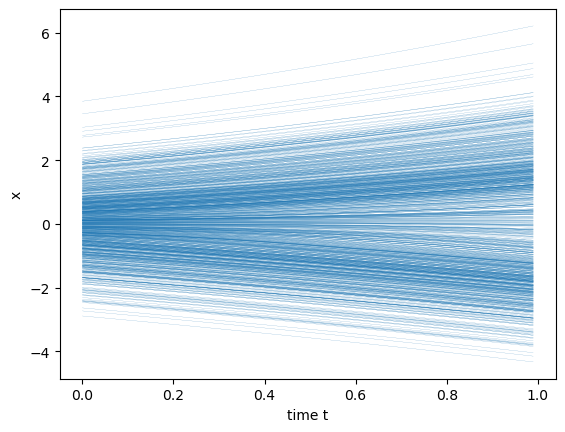

In [55]:
plt.plot(times, trajs, c="tab:blue", lw=0.1)
plt.ylabel("x")
plt.xlabel("time t")
plt.show()

Display the probability path, using kernel density estimation

In [56]:
x_discr = torch.linspace(-4, 4, 100)
probability_path = torch.zeros((len(times), len(x_discr)))
for i in range(len(times)):
    kernel = gaussian_kde(trajs[i])
    probability_path[i] = torch.from_numpy(kernel(x_discr))

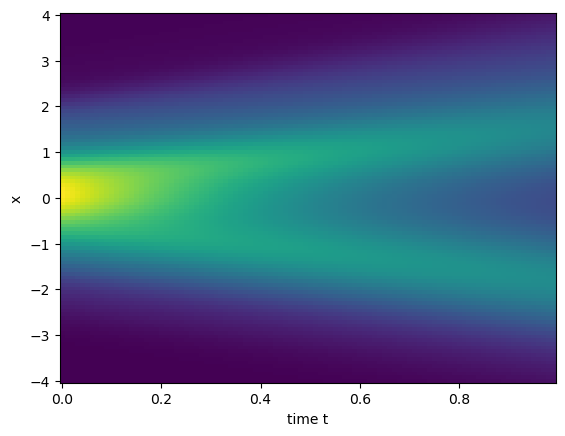

In [57]:
plt.pcolormesh(*np.meshgrid(times, x_discr.numpy()), probability_path.T)
plt.xlabel("time t")
plt.ylabel("x")
plt.show()

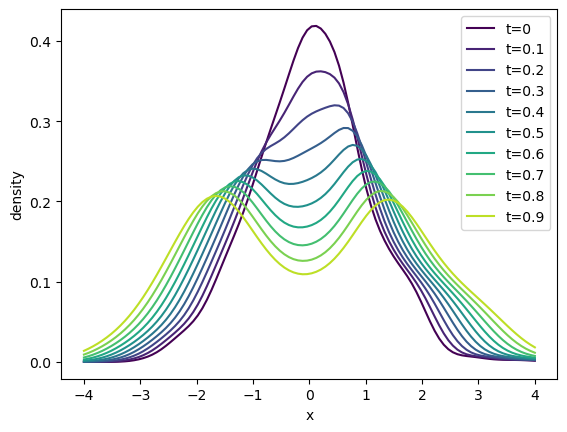

In [58]:
for i in range(0, len(times), 10):
    plt.plot(x_discr, probability_path[i].T, c=plt.colormaps["viridis"](times[i]), label=f"t={times[i]:g}")
plt.legend()
plt.xlabel("x")
plt.ylabel("density")
plt.show()

## 2D distributions

### 0/ Define source and target distributions

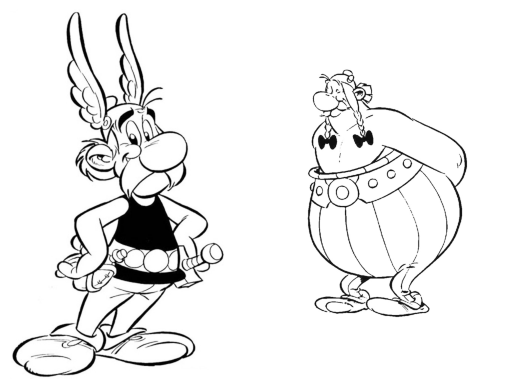

In [33]:
obelix = data_utils.load_image('obelix.jpg')
asterix = data_utils.load_image('asterix.jpg')
plt.subplot(121)
plt.imshow(asterix,cmap='Greys')
plt.axis('off')
plt.subplot(122)
plt.imshow(obelix,cmap='Greys')
plt.axis('off')
plt.show()

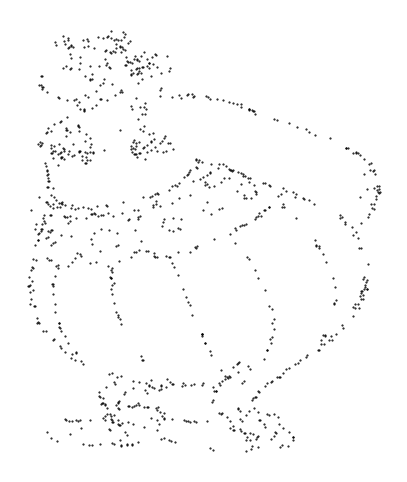

In [34]:
cloud_obelix = data_utils.cloud_transform(obelix, n_samples=1000)
plt.figure(figsize=(5,6))
plt.scatter(cloud_obelix[:,0], cloud_obelix[:,1],marker='.',c='k',s=1)
plt.axis('off')
plt.show()

### 2/ Flow matching from gaussian

In [36]:
reload_all()
args2D = Namespace(dataset="obelix", num_epoch=2000, lr=1e-2, batch_size_train=200, batch_size_test=1000, data_shape=(2,), root=".")
data_loaders2D = data_utils.DataLoaders(args2D.dataset, args2D.batch_size_train, args2D.batch_size_test).load_data()
model2D = models.ODEFunc(dims=(2, 16, 16, 12, 12, 2), bn=True)
model2D

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=12, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=12, out_features=2, bias=True)
  )
)

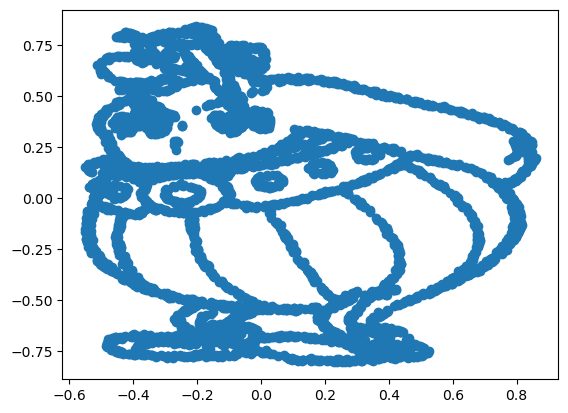

In [39]:
# Check dataloader
obelix_points = torch.cat([batch for batch, _ in data_loaders2D["train"]])
plt.scatter(*obelix_points.T)
plt.show()

In [40]:
fm2D = FLOW_MATCHING(model2D, device=torch.device("cuda"), args=args2D)

In [41]:
fm2D.train(data_loaders2D)

100%|██████████| 2000/2000 [04:45<00:00,  7.01it/s, loss=3.52e-5]


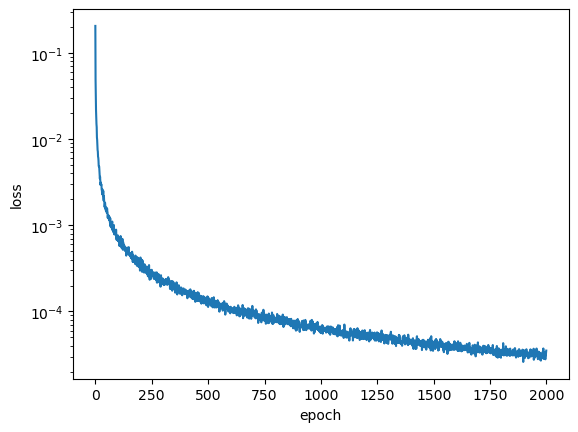

In [48]:
plt.semilogy(fm2D.loss_history)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Compute the trajectories of new samples to sample new points from the target distribution

In [44]:
traj2D = fm2D.apply_flow_matching(1000, np.arange(0, 1, 0.01)).cpu()

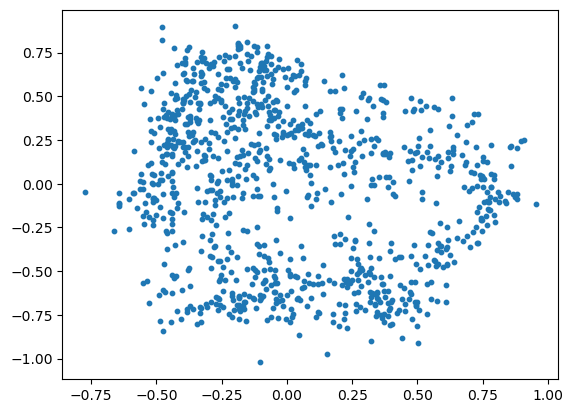

In [45]:
# plt.scatter(*obelix_points.T, s=10)
plt.scatter(*traj2D[-1].T, s=10)
plt.show()

Show some of the trajectories

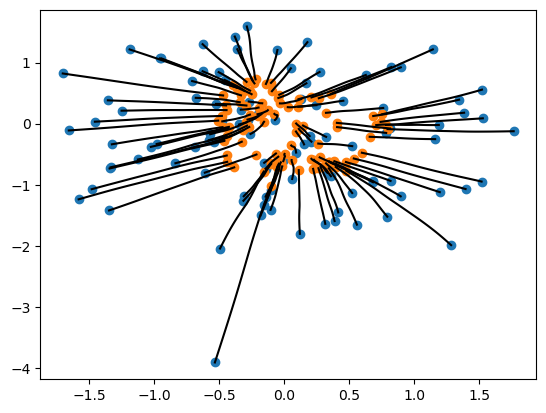

In [46]:
plt.scatter(traj2D[ 0, :100, 0], traj2D[ 0, :100, 1])
plt.scatter(traj2D[-1, :100, 0], traj2D[-1, :100, 1])
plt.plot(traj2D[:, :100, 0], traj2D[:, :100, 1], "k")
plt.show()

### 3/ Flow matching from data distribution